# Sample Hardness
We will look at dataset difficulty and sample hardness using Iris data

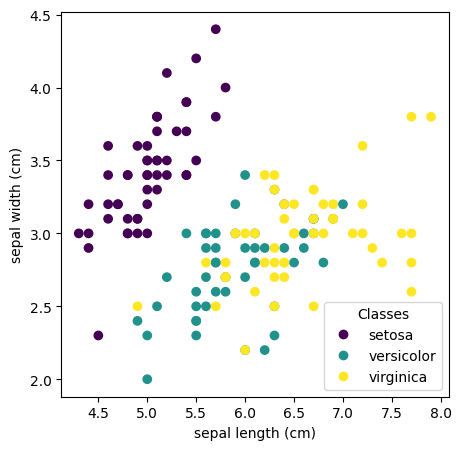

In [46]:
from sklearn.datasets import load_iris
iris = load_iris()

import matplotlib.pyplot as plt

_, ax = plt.subplots(figsize=(5,5))
scatter = ax.scatter(iris.data[:, 0], iris.data[:, 1], c=iris.target)
ax.set(xlabel=iris.feature_names[0], ylabel=iris.feature_names[1])
_ = ax.legend(
    scatter.legend_elements()[0], iris.target_names, loc="lower right", title="Classes"
)

Iris is a relative easy dataset. We will pick two features, and pick _versicolor_ and _virginica_ lables as there seems to be some overalp in the feature space. We will look at this two dimensional data from many angles and see what can we learn about

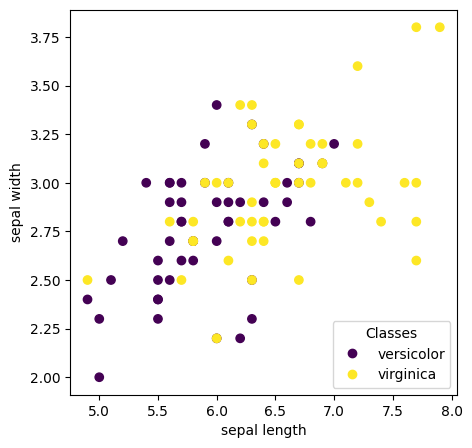

In [47]:

y = iris.target
ind = (y==1) | (y==2)
X = iris.data[ind, 0:2]
y = y[ind]-1

_, ax = plt.subplots(figsize=(5,5))
scatter = ax.scatter(X[:, 0], X[:, 1], c=y)
ax.set(xlabel='sepal length', ylabel='sepal width')
_ = ax.legend(
    scatter.legend_elements()[0], ['versicolor', 'virginica'], loc="lower right", title="Classes"
)

# clean up the variables

We will build a simple linear model (no interactions), then an MLP, use the Linear Model to define sample hardness.
Later, we will remove those points, and retrain an MLP. And see the difference. Along the way, we will see different sample hardness measures.

In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=11)

import numpy as np
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
yh_train = clf.predict(X_train)

from sklearn.metrics import classification_report
print('on train set')
print(classification_report(y_train, yh_train, target_names=['versicolor','virginica']))

yh_test = clf.predict(X_test)
print('on test set')
print(classification_report(y_test, yh_test, target_names=['versicolor','virginica']))

on train set
              precision    recall  f1-score   support

  versicolor       0.69      0.72      0.71        40
   virginica       0.71      0.68      0.69        40

    accuracy                           0.70        80
   macro avg       0.70      0.70      0.70        80
weighted avg       0.70      0.70      0.70        80

on test set
              precision    recall  f1-score   support

  versicolor       0.82      0.90      0.86        10
   virginica       0.89      0.80      0.84        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



## RMD
Let us compute the Mahalanobis Distance (MD) and Relative Mahalanobis Distance (RMD) to flag RMD score

Ref
[A Simple Fix to Mahalanobis Distance for Improving Near-OOD Detection](https://arxiv.org/abs/2106.09022).  In the paper, while computing the foreground MD, while the means are specific to each class, the covariance is common to all classes. The background model to compute the MD assumes a common mean and covariance. You compute the difference between the foreground MD and the background MD, and take the minimum.

But it is must simpler to implement (using sklearn covariance APIs) MD and RMD with class specific covariance.   We will implement this slight modification of RMD for a two class problem.


1st group (40, 2)
1st group (40, 2)


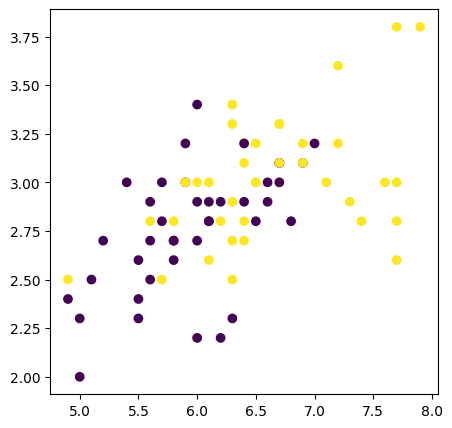

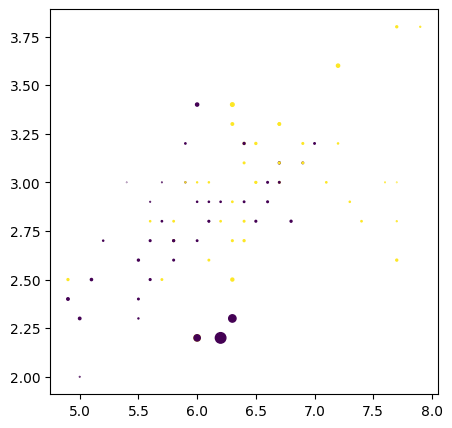

In [49]:
# let us compute RMD for this two features
from sklearn.covariance import EmpiricalCovariance, MinCovDet
X1 = X_train[y_train==0,:]
print('1st group', X1.shape)
X2 = X_train[y_train==1,:]
print('1st group', X2.shape)

# class-specific covariances
Sig1 = MinCovDet().fit(X1)
Sig2 = MinCovDet().fit(X2)
# covariance for the entire data, dropping the class labels
Sig = MinCovDet().fit(X_train)

# sklearn has mahalanobis functions. we don't have to implement
m1 = Sig1.mahalanobis(X_train)
m2 = Sig2.mahalanobis(X_train)
m = Sig.mahalanobis(X_train)

rmd_1 = (m1-m)
rmd_2 = (m2-m)


# take the min of m1, m2 for each record, subtract m. will take exp to keep them positive.
conf_rmd  = np.exp(-np.minimum(rmd_1, rmd_2))

_, ax = plt.subplots(figsize=(5,5))
scatter = ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

_, ax = plt.subplots(figsize=(5,5))
scatter = ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train,s=conf_rmd)


## Margins
Given some representation of the data (or embedding), we can use very well known ML techniques to come up similar statistics like RMD. For example, we can fit an SVM, and calculate the margins for each instance. Not only we solve the prediciton problem, we can get secondary statistics, which are useful in determining the difficulty of the sample to the model.

In [50]:
from sklearn.svm import LinearSVC
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn import svm

clf = svm.SVC(kernel="linear", C=1000)
clf.fit(X_train, y_train)

y_test = clf.predict(X_test)
print('on test set')
print(classification_report(y_train, yh_train, target_names=['versicolor','virginica']))

print('on test set')
print(classification_report(y_test, yh_test, target_names=['versicolor','virginica']))

on test set
              precision    recall  f1-score   support

  versicolor       0.69      0.72      0.71        40
   virginica       0.71      0.68      0.69        40

    accuracy                           0.70        80
   macro avg       0.70      0.70      0.70        80
weighted avg       0.70      0.70      0.70        80

on test set
              precision    recall  f1-score   support

  versicolor       1.00      0.85      0.92        13
   virginica       0.78      1.00      0.88         7

    accuracy                           0.90        20
   macro avg       0.89      0.92      0.90        20
weighted avg       0.92      0.90      0.90        20



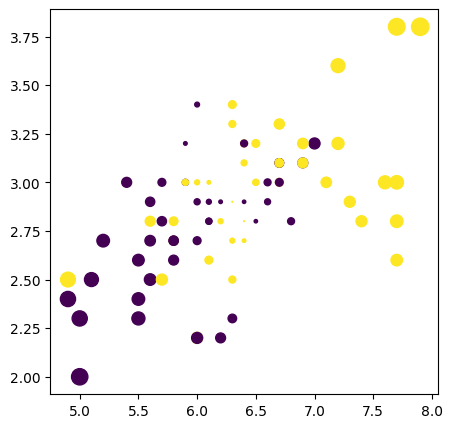

In [51]:
# calculate the margin of all data points in the training set, already available in sklearn
conf = clf.decision_function(X_train)
_, ax = plt.subplots(figsize=(5,5))
scatter = ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train,s=50*np.abs(conf))

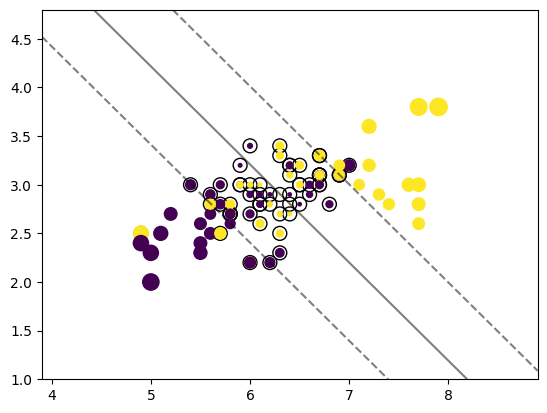

Train size 80
# of support vectors 56


In [52]:
# plot the decision function

ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    clf,
    X_train,
    plot_method="contour",
    colors="k",
    levels=[-1, 0, 1],
    alpha=0.5,
    linestyles=["--", "-", "--"],
    ax=ax,
)
# plot support vectors
ax.scatter(
    clf.support_vectors_[:, 0],
    clf.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="k",
)
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train,s=50*np.abs(conf))
plt.show()

print('Train size', len(X_train))
print('# of support vectors', len(clf.support_vectors_))

At inference time, we can flag instances with low confidence. A simple heuristic to flag us, the confidence score has to be greater than the confidence of the suppost vectors.

In [53]:
# get the smallest confidence that is not of a support vector
sv = clf.support_
# get the conf of those support vectors
conf_sv = clf.decision_function(X_train[sv,:])


# get conf of all points in the train set
conf = clf.decision_function(X_train)
print('conf',conf.shape)

# get the mix conf of SVs from the training data
thresh = np.max(conf_sv)

print('max conf of support vectors is: ', thresh)

conf (80,)
max conf of support vectors is:  1.2440925839422636


Either we can remove the points with low confidence and re-train the model, or pass a sample weight based on the confidence, and retrain the model.

In [54]:
# At inference time, flag test points as low conf or high conf
conf_test = clf.decision_function(X_test)

ind_high_conf = np.where(conf_test > thresh)
print('Test points that with high confidence', ind_high_conf[0].tolist())

ind_low_conf = np.where(conf_test <= thresh)
print('Test points that with low confidence', ind_low_conf[0].tolist())

Test points that with high confidence [13]
Test points that with low confidence [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19]


We can look at the accuracy of test data on high conf and low conf data points on train set, as we seem to have not many points in the test set.

In [55]:
conf_train = clf.decision_function(X_train)
ind_high_conf = np.where(conf_train > thresh)[0].tolist()

yh_high_conf = clf.predict(X_train[ind_high_conf,:])
print('on train set: high conf')
print(classification_report(y_train[ind_high_conf], yh_high_conf))

ind_low_conf = np.where(conf_train <= thresh)[0].tolist()

yh_low_conf = clf.predict(X_train[ind_low_conf,:])
print('on train set: low conf')
print(classification_report(y_train[ind_low_conf], yh_low_conf))


on train set: high conf
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        10

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

on train set: low conf
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        40
           1       0.54      0.47      0.50        30

    accuracy                           0.60        70
   macro avg       0.59      0.58      0.58        70
weighted avg       0.59      0.60      0.60        70



We achieve perfect accuracy on the train set in which all samples have high confidence.
And accuracy is around ~ 60% on the samples with low confidence. 
This demonstrates an important aspect -- not all samples will have equal degree of confidence, and if there is a way to flag them, and deal with in the downstream task, we can bring reliability into the system.

We have chosen the threshold based on some intuition that, typically support vectors will be closed to the separating hyper plans and will exactly sit on the hyperplanes. So, if we choose points whose are farther from the support vectors, they should be farther away from the decision boundary and hence easy to classify. 

But this way of choosing the thresholds does not give any statistical guarantees. One to has to choose the threshold via some cross-validation procedure. Later, we will see conformalization techniques which address this issue.

One way to incorporate the confidence or sample easiness into training procedure is to, remove all difficult examples and retrain the model. Or convert the RMD or other types scores into weights and use a weighted loss, instead.

This paper [Learning Sample Difficulty from Pre-trained Models for Reliable Prediction](https://arxiv.org/abs/2304.10127) uses a score based on RMD to reweigh the samples in loss function.



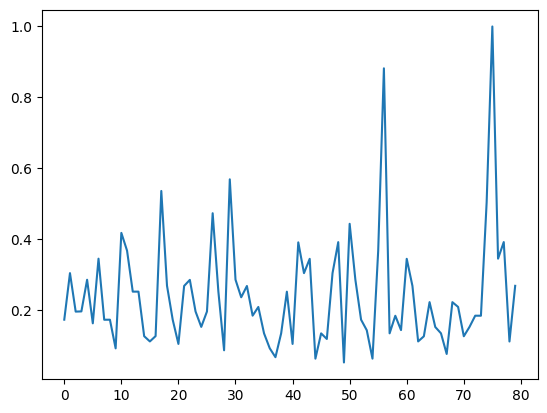

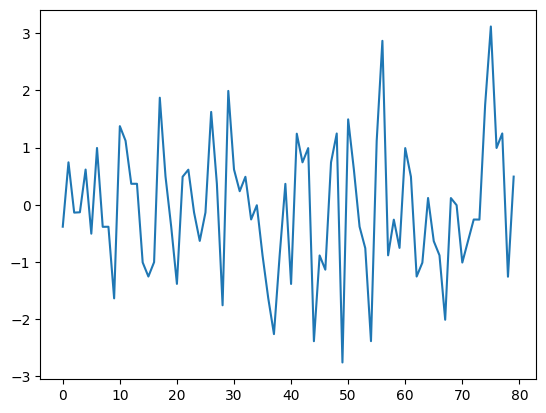

In [62]:
# create weight from conf, and fit a logistic regression with weighed samples
weights = np.exp(0.5*conf)
scaler = np.max(weights)
weights = weights/scaler
plt.plot(weights)
plt.show()
plt.plot(conf)

In [64]:


# fit a logistic model with sampled weights
weighed_model = LogisticRegression(random_state=0).fit(X_train, y_train, sample_weight=weights)
yh_test = weighed_model.predict(X_test)

# get conf from margins of svm
conf_test = clf.decision_function(X_test)
test_weights = np.exp(conf_test)/scaler

print('on test set w/o weights')
print(classification_report(y_test, yh_test))

print('on test set with weights')
print(classification_report(y_test, yh_test, sample_weight = test_weights ))


on test set w/o weights
              precision    recall  f1-score   support

           0       1.00      0.62      0.76        13
           1       0.58      1.00      0.74         7

    accuracy                           0.75        20
   macro avg       0.79      0.81      0.75        20
weighted avg       0.85      0.75      0.75        20

on test set with weights
              precision    recall  f1-score   support

           0       1.00      0.41      0.58 1.5365777483728735
           1       0.78      1.00      0.88 3.298054168177313

    accuracy                           0.81 4.834631916550187
   macro avg       0.89      0.70      0.73 4.834631916550187
weighted avg       0.85      0.81      0.78 4.834631916550187



Overall accuracy improves. Based on our earlier observations, we can predict class 1 much better than class 0. Interestingly, this can also be interpreted as a different form of regularization. Typically, one would place a constraint on the norm of the parameters, implying, one is enforcing smoothness constraints on the functional space. Here, by reweighting the loss, the learning algorithm gives less importance is difficulty samples, there by, the function to be fit, need to do lot of hard work (i.e very complex function) but a simpler function (meaning smooth function) would suffice. So, while the goal is same (smooth function), the way one goes about can be different. The path of regularization, to a large extent, is a brute-force approach, but reweighting one exactly knowns what is the influence of each example in the training.